/opt/anaconda/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


First column: X17Networks_LH_VisCent_ExStr_1
(should be 'X17Networks_LH_VisCent_ExStr_1')
Last column: CAU.lh (should be 'CAU.lh)


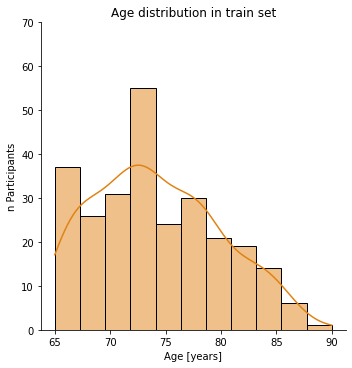

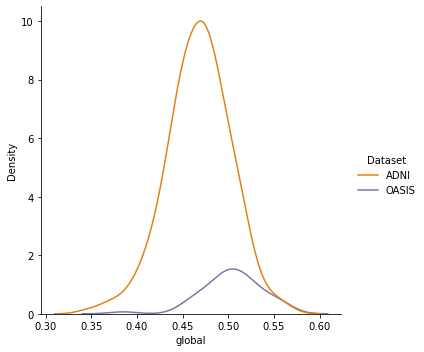

In [1]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plots

from skrvm import RVR
from julearn import run_cross_validation
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

# %%
# matplotlib config
cm_all = pickle.load(open("../data/config/plotting_config.p", "rb"))

# %%
# LOAD DATA
# load and inspect data, set modality
# TODO: stratify by age group (young old, middle old, oldest-old)
# modality = input("Which modality are you analyzing? ")
modality = 'MRI'
database = "1_CN_ADNI_OASIS"
mode = "train"
df = pd.read_csv('../data/ADNI/test_train_' + modality + '.csv', sep=";")
df['PTGENDER'] = [0 if x == "Male" else 1 for x in df['PTGENDER'].values]
df_train = df[df['train']]
# select columns with '_' which are col's with features
col = df.columns[4:-23].tolist()
print("First column: {}".format(col[0]) +
      "\n(should be 'X17Networks_LH_VisCent_ExStr_1')" +
      "\nLast column: {}".format(col[-1]) +
      " (should be 'CAU.lh)")

df_train = df_train.reset_index(drop=True)

# plot hist with Ages of train data
sns.displot(df_train, x='age', kde=True, color=cm_all[0])
plt.ylim(0, 70)
plt.title('Age distribution in train set')
plt.xlabel('Age [years]')
plt.ylabel('n Participants')
plt.savefig('../results/{}/plots/{}_age_distribution'.format(database,
                                                             modality) +
            '_train.png', bbox_inches="tight")
plt.show()


# %%
# DATA INVESTIGATION
# how are brain signals distributed in OASIS and ADNI?
# plot global brain signal
df['global'] = np.mean(df[col], axis=1)
sns.displot(df, x='global', kind='kde', hue='Dataset', palette=cm_all)
plt.savefig('../results/{}/plots/{}_signal_distribution.jpg'.format(database,
                                                                    modality),
            bbox_inches='tight')
plt.show()

In [2]:
# %%
# PREPARATION
rand_seed = 42
num_bins = 5

# define models and model names (some are already included in julearn)
rvr = RVR()

# models to test & names
models = [rvr, 'svm', 'gradientboost']
model_names = ['rvr', 'svm', 'gradientboost']

splits = 5

# model params
model_params = pickle.load(open("../data/config/hyperparams_allmodels.p",
                                "rb"))

# %%
# TRAINING
# train models using 5-fold cross-validation
model_results = []
scores_results = []

for i, (model, params) in enumerate(zip(models, model_params)):
    # split data using age-bins instead of real age
    cv = StratifiedKFold(n_splits=splits).split(df_train[col],
                                                df_train['Ageb'])
    cv = list(cv)
    # run julearn function
    scores, final_model = run_cross_validation(X=col, y='age',
                                               preprocess_X='scaler_robust',
                                               problem_type='regression',
                                               data=df_train,
                                               model=model, cv=cv,
                                               seed=rand_seed,
                                               # confounds='PTGENDER',
                                               model_params=params,
                                               return_estimator='all',
                                               scoring=['r2',
                                                        'neg_mean_absolute_error'])
    model_results.append(final_model.best_estimator_)
    scores_results.append(scores)
    print(model, scores['test_neg_mean_absolute_error'].mean())

RVR() -4.1974227276291405
svm -3.973603726861879
gradientboost -4.170643458704855


rvr 1.9383941130206819 0.8318064428709526 -0.000444836995980346
svm 3.3350298791991153 0.40570074613483076 -0.44285166498039685
gradientboost 0.644925671256658 0.981353626869 1.3726393759001936e-14


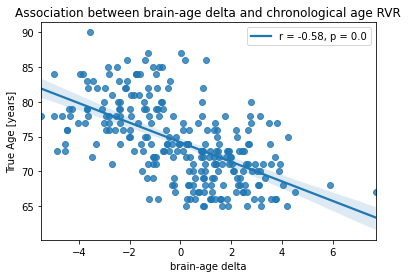

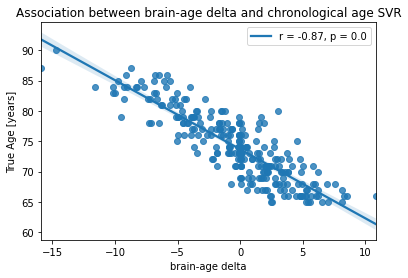

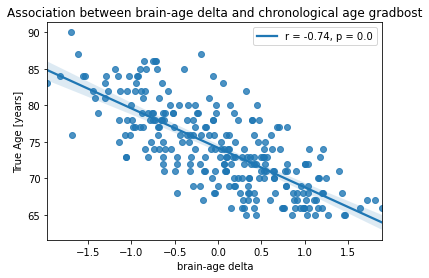

Significant association between RVR-predicted age delta and CA: True
Significant association between SVR-predicted age delta and CA: True
Significant association between gradboost-predicted age delta and CA: True
--- rvr ---
On average, predicted age of 1_CN_ADNI_OASIS differed by 2.799107746933728e-15 years from their chronological age.
MAE = 1.515891641473356, R2 = 0.8875317137131292


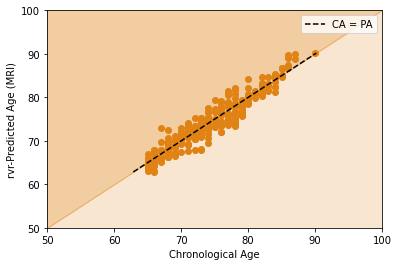

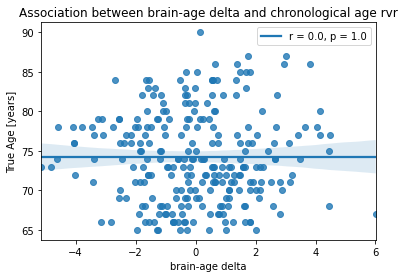

--- svm ---
On average, predicted age of 1_CN_ADNI_OASIS differed by -8.074349270001139e-17 years from their chronological age.
MAE = 1.641698577795934, R2 = 0.8592382341297912


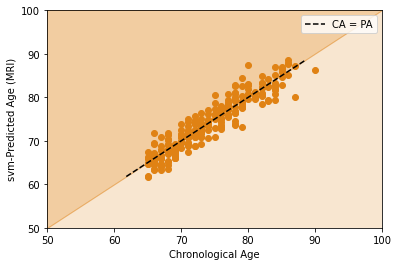

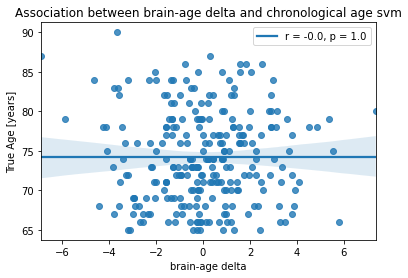

--- gradientboost ---
On average, predicted age of 1_CN_ADNI_OASIS differed by 5.921189464667501e-16 years from their chronological age.
MAE = 0.42731636265844836, R2 = 0.9914822263386112


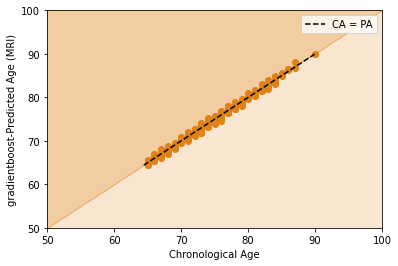

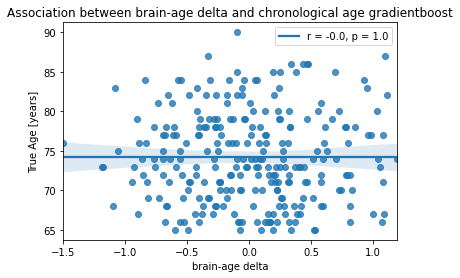

In [19]:
from sklearn.metrics import mean_absolute_error, r2_score
# BIAS CORRECTION DO NOT EXECUTE BEFORE SAVING OTHER RESULTS
y_true = df_train['age']
y_pred_rvr = model_results[0].predict(df_train[col])
y_pred_svr = model_results[1].predict(df_train[col])
y_pred_gb = model_results[2].predict(df_train[col])

pred = [y_pred_rvr, y_pred_svr, y_pred_gb]
for i in range(len(pred)):
    p = pred[i]
    print(model_names[i],
          mean_absolute_error(y_true, p),
          r2_score(y_true, p),
          np.mean(p-y_true))
    

correct_with_CA = True

slope_rvr, intercept_rvr, rvr_check = plots.check_bias(y_true,
                                                       y_pred_rvr,
                                                       'RVR',
                                                       modality,
                                                       database,
                                                       correct_with_CA)
slope_svr, intercept_svr, svr_check = plots.check_bias(y_true,
                                                       y_pred_svr,
                                                       'SVR',
                                                       modality,
                                                       database,
                                                       correct_with_CA)
slope_gb, intercept_gb, gb_check = plots.check_bias(y_true,
                                                    y_pred_gb,
                                                    'gradbost',
                                                    modality,
                                                    database,
                                                    correct_with_CA)

print("Significant association between RVR-predicted age delta and CA:",
      rvr_check)
print("Significant association between SVR-predicted age delta and CA:",
      svr_check)
print("Significant association between gradboost-predicted age delta and CA:",
      gb_check)

# %%
# BIAS CORRECTION
# Eliminate linear correlation of brain age delta and chronological age

# relevance Vectors Regression
y_true = df_train['age']

if correct_with_CA:
    # for age correction WITH chronological age
    y_pred_rvr_bc = y_pred_rvr - (slope_rvr*y_true + intercept_rvr)
    y_pred_svr_bc = y_pred_svr - (slope_svr*y_true + intercept_svr)
    y_pred_gb_bc = y_pred_gb - (slope_gb*y_true + intercept_gb)
else:
    # for age correction WITHOUT chronological age
    y_pred_rvr_bc = (y_pred_rvr - intercept_rvr)/slope_rvr
    y_pred_svr_bc = (y_pred_svr - intercept_svr)/slope_svr
    y_pred_gb_bc = (y_pred_gb - intercept_gb)/slope_gb

pred_bc = [y_pred_rvr_bc, y_pred_svr_bc, y_pred_gb_bc]

for i in range(len(pred_bc)):
    plots.real_vs_pred_2(y_true, pred_bc[i], model_names[i], modality,
                         mode, database_name=database)
    plots.check_bias(y_true, pred_bc[i], model_names[i], modality,
                     database, corrected=True)

# %%
# SAVE MODELS
model_rvr = {'intercept': intercept_rvr,
             'slope': slope_rvr,
             'model': model_results[0]}
model_svr = {'intercept': intercept_svr,
             'slope': slope_svr,
             'model': model_results[1]}
model_gb = {'intercept': intercept_gb,
            'slope': slope_gb,
            'model': model_results[2]}

pickle.dump(model_rvr, open("../results/" + database +
                            "/model_rvr_" + modality +
                            ".p", "wb"))
pickle.dump(model_svr, open("../results/" + database +
                            "/model_svr_" + modality +
                            ".p", "wb"))
pickle.dump(model_gb, open("../results/" + database +
                           "/model_gb_" + modality +
                           ".p", "wb"))
